In [1]:
# Download the curated list of genomes

!wget -nc https://storage.googleapis.com/bioshield-bucket/bioshield/genomes.fasta
!wget -nc https://storage.googleapis.com/bioshield-bucket/bioshield/SF17_ViralChEMBL_dataset.csv
!mkdir ./data && mv *.fasta ./data/ && mv *.csv ./data/

File ‘genomes.fasta’ already there; not retrieving.

File ‘SF17_ViralChEMBL_dataset.csv’ already there; not retrieving.



# Creating the Dataset for the Seq2Seq Genome to SMILE model

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
# Create the map VirName --> Genome

virus_genomes = open('./data/genomes.fasta').readlines()

virus_genomes_map = {}

vir_name = ""
genome = ""

for line in virus_genomes:
    line = line.strip()
    if line.find('|') != -1:
        if vir_name != "":
            if vir_name not in virus_genomes_map:
                len_gen = 0
            else:
                len_gen = len(virus_genomes_map[vir_name])
            if len(genome) > len_gen:
                virus_genomes_map[vir_name] = genome
        line = line.split('|')
        vir_name = line[3]#.split(',')[0]
        genome = ""
        continue
    genome += line

In [4]:
complete_genomes_keys = [k for k in virus_genomes_map.keys()]

In [5]:

mol = pd.read_csv('./data/SF17_ViralChEMBL_dataset.csv')

/Users/zarbo/miniconda3/envs/bioshield/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
chembio_id = 'assay_chembl_id'
species_name = 'species_name'

unique_molecules = np.array([x for x in np.unique(mol[chembio_id].values.astype(str)) if x.lower() != 'nan' and x.lower() != 'unassigned'])
unique_viruses = np.array([x for x in np.unique(mol[species_name].values.astype(str)) if x.lower() != 'nan' and x.lower() != 'unassigned'])

print('Total Len of Dataset:',len(mol[chembio_id].values))
print('Number of Molecules:', unique_molecules.shape)
print('Number of Spieces:', unique_viruses.shape)

Total Len of Dataset: 615029
Number of Molecules: (37349,)
Number of Spieces: (168,)


In [7]:
# Check the existance of the viruses found in the dataset and the genomes downloaded

spieces_found = []
spieces_not_found = []
spieces_found_to_gen = {}
for spiece in unique_viruses:
    spiece_found_list = []
    for sp_gn in complete_genomes_keys:
        sp_gn_norm = sp_gn.lower().split(',')[0]
        spiece_norm = spiece.lower().split(' ')
        spiece_found = spiece.lower() == sp_gn_norm 
        
        if spiece_found:
            spiece_found_list.append(sp_gn)
    if len(spiece_found_list) > 0:
        spieces_found.append((spiece,spiece_found_list))
        if spiece not in spieces_found_to_gen:
            spieces_found_to_gen[spiece] = {}
        for sp_gn in spiece_found_list:
            spieces_found_to_gen[spiece][sp_gn]= virus_genomes_map[sp_gn]
    else:
        spieces_not_found.append(spiece)

keys_to_drop = []

for spieces, spieces_list in spieces_found_to_gen.items():
    spieces_list_keys_norm = [k.lower().split(',')[0] for k in spieces_list.keys() if k.lower().split(',')[1].find('complete') != -1 ]
    if spieces.lower() in spieces_list_keys_norm:
        for k in spieces_list.keys():
            if k.lower().split(',')[0] != spieces.lower():
                keys_to_drop.append((spieces,k))
                
for k_to_drop in keys_to_drop:
    spieces_found_to_gen[k_to_drop[0]].pop(k_to_drop[1])

if 'nan' in spieces_found_to_gen:
    spieces_found_to_gen.pop('nan')
print('Succed')

Succed


In [8]:
print("Virus found in both dataset: ", len(spieces_found)*100 / len(unique_viruses), "%")

Virus found in both dataset:  100.0 %


In [9]:
# Creating the complete dataset Genomes to Canonical SMILE
min_gen_len = 19000
max_gen_len = 32768

max_len_mol = 128

dataset_gen_to_mol = {
    'genetic_code':[],
    'molecule':[],
    'canonical_smiles':[],
    'viralchembl_name':[],
    'refseq_name':[]
}

for i in tqdm(range(len(mol))):
    row = mol.iloc[i]
    sp_name = row[species_name]
    mol_name = row[chembio_id]
    can_smile = row['canonical_smiles']
    
    for sp_name_found, sp_gn_key_list in spieces_found:
        if sp_name == sp_name_found:
            for sp_gn_key in sp_gn_key_list:
                if (min_gen_len <= len(spieces_found_to_gen[sp_name][sp_gn_key]) <= max_gen_len) and len(can_smile) <= max_len_mol:
                    dataset_gen_to_mol['viralchembl_name'].append(sp_name)
                    dataset_gen_to_mol['refseq_name'].append(sp_gn_key)
                    dataset_gen_to_mol['molecule'].append(mol_name)
                    dataset_gen_to_mol['canonical_smiles'].append(can_smile)
                    dataset_gen_to_mol['genetic_code'].append(spieces_found_to_gen[sp_name][sp_gn_key])
            break


100%|██████████| 615029/615029 [02:35<00:00, 3960.89it/s]


In [10]:
# Creating Pandas Dataframe
dataset_gen_to_mol_df = pd.DataFrame(dataset_gen_to_mol)
# Checking the contents
dataset_gen_to_mol_df

,genetic_code,molecule,canonical_smiles,viralchembl_name,refseq_name
0,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL748339,Cc1ccc(cc1)S(=O)(=O)O.N\C(=N/O)\N\N=C\c2ccc(O)...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
1,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL748339,Cc1ccc(cc1)S(=O)(=O)O.N\C(=N/O)\N\N=C\c2ccccc2O,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
2,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL748339,Cc1ccc(cc1)S(=O)(=O)O.N\C(=N/O)\N\N=C\c2cc(Br)...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
3,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL748339,Cc1ccc(cc1)S(=O)(=O)O.N\C(=N/O)\N\N=C\c2c3cccc...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
4,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL748339,Cc1ccc(cc1)S(=O)(=O)O.N\C(=N/O)\N\N=C\c2cccc(C...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
...,...,...,...,...,...
95840,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL3254578,[Li+].[Li+].NC(=O)c1ncn(n1)[C@@H]2O[C@H](COP(=...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
95841,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL3254581,[Li+].[Li+].NC(=O)c1ncn(n1)[C@@H]2O[C@H](COP(=...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
95842,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL3254582,[Li+].[Li+].NC(=O)c1ncn(n1)[C@@H]2O[C@H](COP(=...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"
95843,TATAAGAGTGATTGGCGTCCGTACGTACCCTCTCAACTCTAAAACT...,CHEMBL3254583,[Li+].[Li+].NC(=O)c1ncn(n1)[C@@H]2O[C@H](COP(=...,Murine hepatitis virus,"Murine hepatitis virus, complete genome"


In [11]:
# Saving the total dataset
dataset_gen_to_mol_df.to_csv('./data/gen_to_mol.csv', index=False)

In [12]:
# Split the Virus in Training (TR), Test (TS) and Validation (VAL)
unique_virs_num = np.unique(dataset_gen_to_mol_df['viralchembl_name'].values)
np.random.shuffle(unique_virs_num)

idx_limit_tr = int(unique_virs_num.shape[0]*0.8)
idx_limit_ts = int(unique_virs_num.shape[0]*0.9)

tr_virs = unique_virs_num[:idx_limit_tr]
ts_virs = unique_virs_num[idx_limit_tr:idx_limit_ts]
val_virs = unique_virs_num[idx_limit_ts:]

print('Viruses in Training')
print(tr_virs)
print('Viruses in Testing')
print(ts_virs)
print('Viruses in Validation')
print(val_virs)



Viruses in Training
['Marburg marburgvirus isolate Ravn' 'Murine mastadenovirus A'
 'Bovine coronavirus'
 'Severe acute respiratory syndrome-related coronavirus' 'Nam Dinh virus'
 'Feline infectious peritonitis virus' 'Infectious bronchitis virus'
 'Human coronavirus HKU1']
Viruses in Testing
['Human coronavirus NL63']
Viruses in Validation
['Murine hepatitis virus' 'Human coronavirus 229E']


In [13]:
# Creating the sub dataset for TR, TS and VAL
dataset_gen_to_mol_tr = {
    'genetic_code':[],
    'molecule':[],
    'canonical_smiles':[],
    'viralchembl_name':[],
    'refseq_name':[]
}

dataset_gen_to_mol_ts = {
    'genetic_code':[],
    'molecule':[],
    'canonical_smiles':[],
    'viralchembl_name':[],
    'refseq_name':[]
}

dataset_gen_to_mol_val = {
    'genetic_code':[],
    'molecule':[],
    'canonical_smiles':[],
    'viralchembl_name':[],
    'refseq_name':[]
}

for i in tqdm(range(len(dataset_gen_to_mol_df))):
    row = dataset_gen_to_mol_df.iloc[i]
    
    genetic_code = row['genetic_code']
    molecule = row['molecule']
    canonical_smiles = row['canonical_smiles']
    viralchembl_name = row['viralchembl_name']
    refseq_name = row['refseq_name']
    
    if viralchembl_name in tr_virs:
        dataset_gen_to_mol_tr['viralchembl_name'].append(viralchembl_name)
        dataset_gen_to_mol_tr['refseq_name'].append(refseq_name)
        dataset_gen_to_mol_tr['molecule'].append(molecule)
        dataset_gen_to_mol_tr['canonical_smiles'].append(canonical_smiles)
        dataset_gen_to_mol_tr['genetic_code'].append(genetic_code)
    elif viralchembl_name in ts_virs:
        dataset_gen_to_mol_ts['viralchembl_name'].append(viralchembl_name)
        dataset_gen_to_mol_ts['refseq_name'].append(refseq_name)
        dataset_gen_to_mol_ts['molecule'].append(molecule)
        dataset_gen_to_mol_ts['canonical_smiles'].append(canonical_smiles)
        dataset_gen_to_mol_ts['genetic_code'].append(genetic_code)
    elif viralchembl_name in val_virs:
        dataset_gen_to_mol_val['viralchembl_name'].append(viralchembl_name)
        dataset_gen_to_mol_val['refseq_name'].append(refseq_name)
        dataset_gen_to_mol_val['molecule'].append(molecule)
        dataset_gen_to_mol_val['canonical_smiles'].append(canonical_smiles)
        dataset_gen_to_mol_val['genetic_code'].append(genetic_code)
    else:
        print('Virus:', viralchembl_name,'Not Found')

dataset_gen_to_mol_df_tr = pd.DataFrame(dataset_gen_to_mol_tr)
dataset_gen_to_mol_df_ts = pd.DataFrame(dataset_gen_to_mol_ts)
dataset_gen_to_mol_df_val = pd.DataFrame(dataset_gen_to_mol_val)

dataset_gen_to_mol_df_tr.to_csv('./data/gen_to_mol_tr.csv', index=False)
dataset_gen_to_mol_df_ts.to_csv('./data/gen_to_mol_ts.csv', index=False)
dataset_gen_to_mol_df_val.to_csv('./data/gen_to_mol_val.csv', index=False)

100%|██████████| 95845/95845 [00:19<00:00, 5028.21it/s]


In [14]:
length_distribution = []
for i in tqdm(range(len(dataset_gen_to_mol_df))):
    row = dataset_gen_to_mol_df.iloc[i]
    length_distribution.append(len(row['genetic_code']))
    

100%|██████████| 95845/95845 [00:11<00:00, 8342.51it/s]


In [15]:
print('Median:',np.median(length_distribution))
print('Mean:',np.mean(length_distribution))
print('Max:',np.max(length_distribution))

Median: 19114.0
Mean: 19389.300474724816
Max: 31357


In [16]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff

init_notebook_mode(connected=True)
cf.go_offline()


In [17]:
len_df = pd.DataFrame({'len':length_distribution})


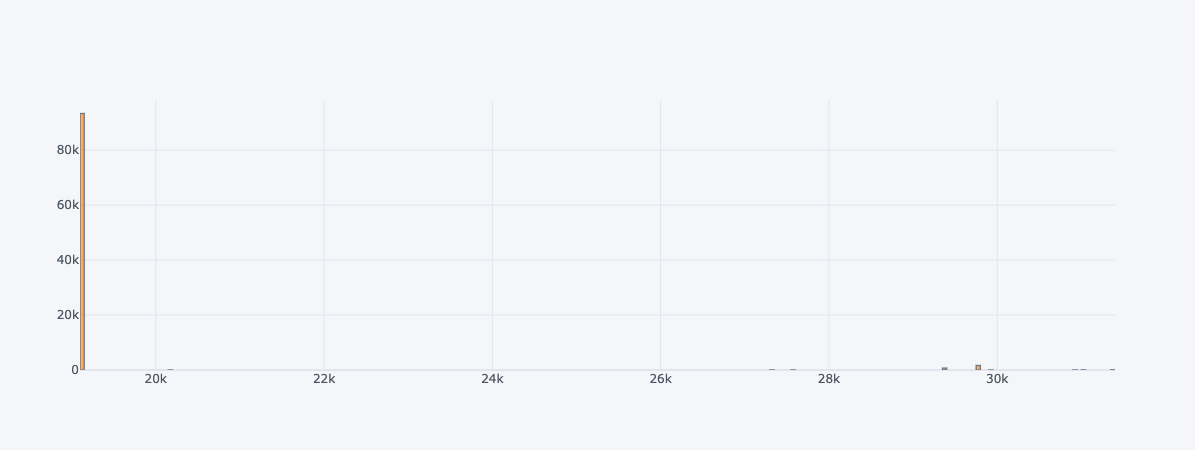

In [18]:
len_df.iplot(kind='histogram')

# Creating the Dataset for the Molecular Similarity Experiment

In [19]:
# Creating map SMILE to ChemicalID
smile_to_id = {}
problems = 0
for i in tqdm(range(len(mol))):
    row = mol.iloc[i]
    assay_chembl_id = row['assay_chembl_id']
    canonical_smiles = row['canonical_smiles']
    if canonical_smiles in smile_to_id:
        assay_chembl_id_old =  smile_to_id[canonical_smiles]
        if assay_chembl_id_old != assay_chembl_id:
            #print('Smile already found with different chem_id.')
            #print('canonical_smiles:', canonical_smiles)
            #print('assay_chembl_id_old:', assay_chembl_id_old)
            #print('assay_chembl_id:', assay_chembl_id)
            problems += 1
    smile_to_id[canonical_smiles] = assay_chembl_id
    
print('Number of problems found:', problems)

100%|██████████| 615029/615029 [02:01<00:00, 5060.94it/s]

Number of problems found: 339079


In [20]:
# Creating map ChemicalID to SMILE
id_to_smile = {}

for k,v in tqdm(smile_to_id.items()):
    if v not in id_to_smile:
        id_to_smile[v] = []
    id_to_smile[v].append(k)

100%|██████████| 263057/263057 [00:00<00:00, 1630653.65it/s]


In [21]:
# Creating the dataset for Training / Testing and Validation for the SMILE Similarity Model
chem_id_tr = []
chem_id_ts = []
chem_id_val = []
i_limit_tr = len(id_to_smile.keys()) * 0.8
i_limit_ts = len(id_to_smile.keys()) * 0.9
for i,k in tqdm(enumerate(id_to_smile.keys())):
    if i <= i_limit_tr:
        chem_id_tr.append(k)
    elif i_limit_tr < i <= i_limit_ts:
        chem_id_ts.append(k)
    elif i > i_limit_ts:
        chem_id_val.append(k)
    else:
        print('Wrong limits defined')
        

7982it [00:00, 1369897.89it/s]


In [22]:
def create_dataset(chem_id_list, id_to_smile_org, num_positive, num_negative):
    chem_similarity = {
        'chem1': [],
        'chem2': [],
        'equal': []
    }
    pos_examples = []
    neg_examples = []
    
    id_to_smile = {}
    smile_to_id = {}
    for k,v in id_to_smile_org.items():
        if k in chem_id_list:
            id_to_smile[k]=v
            for can_smls in v:
                smile_to_id[can_smls] = k
    
    max_tentative = 100
    for chem_id in tqdm(id_to_smile.keys()):
        if chem_id not in chem_id_list:
            continue
        smiles_list = id_to_smile[chem_id]
        for _ in range(max_tentative):
            np.random.shuffle(smiles_list)
            v1 = smiles_list[0]
            v2 = smiles_list[-1]
            if (v1,v2) in pos_examples or v1 == v2:
                continue
            if len(pos_examples) < num_positive:
                pos_examples.append((v1,v2))
        if len(pos_examples) >= num_positive:
            break
    print('Found Positive:', len(pos_examples))
    
    smiles_list = list(smile_to_id.keys())
    id_list = list(id_to_smile.keys())
    for _ in tqdm(range(100000)):
        np.random.shuffle(id_list)
        chem1 = id_list[0]
        chem2 = id_list[-1]
        if chem1 == chem2:
            continue
            
        smile1_list = id_to_smile[chem1]
        np.random.shuffle(smile1_list)
        smile1 = smile1_list[0]
        
        smile2_list = id_to_smile[chem2]
        np.random.shuffle(smile2_list)
        smile2 = smile2_list[0]
        
        if smile1 == smile2:
            continue
        
        
        if len(neg_examples) < num_negative:
            if (smile1,smile2) not in neg_examples:
                neg_examples.append((smile1,smile2))
        #if (len(neg_examples) % 1000) == 0 and len(neg_examples) > 0:
            #print('\nArrived at:', len(neg_examples))
            #print('Pos:', len(pos_examples))
            #print('Neg:', len(neg_examples))
            #print('------------------------------------------')
        if len(neg_examples) >= num_negative:
            break
    
    for v1, v2 in pos_examples:
        chem_similarity['chem1'].append(v1)
        chem_similarity['chem2'].append(v2)
        chem_similarity['equal'].append(1)
        
    for v1, v2 in neg_examples:
        chem_similarity['chem1'].append(v1)
        chem_similarity['chem2'].append(v2)
        chem_similarity['equal'].append(0)
    
    return chem_similarity
    

In [23]:
chem_similarity_ts = create_dataset(chem_id_list=chem_id_ts, id_to_smile_org=id_to_smile, num_positive=10000, num_negative=10000)

  3%|▎         | 3307/100000 [00:00<00:05, 17094.70it/s]

Found Positive: 10000


 10%|▉         | 9744/100000 [00:01<00:12, 6949.60it/s] 


In [24]:
chem_similarity_val = create_dataset(chem_id_list=chem_id_val, id_to_smile_org=id_to_smile, num_positive=10000, num_negative=10000)

  2%|▏         | 2032/100000 [00:00<00:04, 20319.20it/s]

Found Positive: 10000


 10%|▉         | 9836/100000 [00:01<00:13, 6610.67it/s] 


In [25]:
chem_similarity_tr = create_dataset(chem_id_list=chem_id_tr, id_to_smile_org=id_to_smile, num_positive=100000, num_negative=100000)

  1%|          | 537/100000 [00:00<00:18, 5366.19it/s]

Found Positive: 100000



100%|██████████| 100000/100000 [03:01<00:00, 550.47it/s][A


In [26]:
chem_similarity_tr_df = pd.DataFrame(chem_similarity_tr)
chem_similarity_ts_df = pd.DataFrame(chem_similarity_ts)
chem_similarity_val_df = pd.DataFrame(chem_similarity_val)

In [27]:
print('Number of Equal in Training:', len(chem_similarity_tr_df.query('equal == 1')))
print('Number of NonEqual in Training:', len(chem_similarity_tr_df.query('equal == 0')))

Number of Equal in Training: 100000
Number of NonEqual in Training: 99980


In [28]:
chem_similarity_tr_df.to_csv('./data/chem_similarity_tr.csv', index=False)
chem_similarity_ts_df.to_csv('./data/chem_similarity_ts.csv', index=False)
chem_similarity_val_df.to_csv('./data/chem_similarity_val.csv', index=False)